<a href="https://colab.research.google.com/github/gkrry2723/ML_pytorch_study/blob/master/4_CNN_%EC%9D%B4%EB%AF%B8%EC%A7%80%ED%95%B4%EC%83%81%EB%8F%84%ED%96%A5%EC%83%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

얼굴 해상도를 향상시키기

1. 얼굴 데이터 다운로드

In [1]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar -zxvf lfw-deepfunneled.tgz
!mkdir lfw-deepfunneled/train
!mv lfw-deepfunneled/[A-W]* lfw-deepfunneled/train
!mkdir lfw-deepfunneled/test
!mv lfw-deepfunneled/[X-Z]* lfw-deepfunneled/test


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0013.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0014.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0015.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0016.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0017.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0018.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0019.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0020.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0021.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg
lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg
lfw-deepfunneled/Luiz_Inacio

얼굴 데이터 크기: 250*250

목표: 32* 32 -> 
      128*128

2. dataset, dataloader 준비 ->(전엔 없던거)

In [8]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

class DownSizedPairImageFolder(ImageFolder):
  def __init__(self,root,transform=None,large_size=128,small_size=32,**kwds):
    super().__init__(root,transform=transform,**kwds)
    self.large_resizer = transforms.Resize(large_size)
    self.small_resizer = transforms.Resize(small_size)
  
  def __getitem__(self,index):
    path, _ = self.imgs[index]
    img = self.loader(path)

    large_img = self.large_resizer(img)
    small_img = self.small_resizer(img)

    if self.transform is not None:
      large_img = self.transform(large_img)
      small_img = self.transform(small_img)
    
    return small_img,large_img

3. 훈련, 검증용 data loader 작성 

In [9]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset,DataLoader,TensorDataset)

train_data = DownSizedPairImageFolder("/content/lfw-deepfunneled/train",transform=transforms.ToTensor())
test_data = DownSizedPairImageFolder("/content/lfw-deepfunneled/test",transform=transforms.ToTensor())

batch_size = 32
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False,num_workers=2)

4. 모델 작성

In [13]:
net = nn.Sequential(
    nn.Conv2d(3,256,4,stride=2,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),

    nn.Conv2d(256,512,4,stride=2,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),

    nn.ConvTranspose2d(512,256,4,stride=2,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),

    nn.ConvTranspose2d(256,128,4,stride=2,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),

    nn.ConvTranspose2d(128,64,4,stride=2,padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),

    nn.ConvTranspose2d(64,3,4,stride = 2, padding=1)

)

5.  훈련모델 구현

- PSNR -> 이미지나 음성등의 신호를 복원하는 처리에선 PSNR을 지표로 더 많이 사용한다.

In [16]:
import math
import tqdm

def psnr(mse,max_v=1.0):
  return 10 * math.log10(max_v**2/mse)

def eval_net(net,data_loader,device = "cpu"):
  net.eval()
  ys = []
  ypreds = []
  for x,y in data_loader:
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
      y_pred = net(x)
    ys.append(y)
    ypreds.append(y_pred)
  
  ys = torch.cat(ys)
  ypreds = torch.cat(ypreds)

  score = nn.functional.mse_loss(ypreds,ys).item()
  return score

def train_net(net, train_loader, test_loader, optimizer_cls=optim.Adam, loss_fn=nn.MSELoss(), n_iter=10, device="cpu"):
  train_losses =[]
  train_acc = []
  val_acc = []
  optimizer = optimizer_cls(net.parameters())

  for epoch in range(n_iter):
    running_loss = 0.0
    net.train()
    n=0
    score =0
    for i,(xx,yy) in tqdm.tqdm(enumerate(train_loader),total = len(train_loader)):
      xx = xx.to(device)
      yy = yy.to(device)
      optimizer.zero_grad()
      y_pred = net(xx)
      loss = loss_fn(y_pred,yy)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      n += len(xx)

    train_losses.append(running_loss / len(train_loader))
    val_acc.append(eval_net(net,test_loader,device))

    print(epoch,train_losses[-1],psnr(train_losses[-1]),psnr(val_acc[-1]),flush=True)




In [17]:
net.to("cuda:0")
train_net(net,train_loader,test_loader,device = "cuda:0")


100%|██████████| 409/409 [00:27<00:00, 14.97it/s]


0 0.008729570786625803 20.590071090530163 23.787755644320207


100%|██████████| 409/409 [00:27<00:00, 14.99it/s]


1 0.0038772753233768612 24.114733588643773 23.99967357292232


100%|██████████| 409/409 [00:27<00:00, 14.88it/s]


2 0.00331792620484305 24.791332774996796 26.063044966548254


100%|██████████| 409/409 [00:27<00:00, 14.91it/s]


3 0.003056121318917585 25.148294095562097 25.890469483410037


100%|██████████| 409/409 [00:27<00:00, 14.99it/s]


4 0.0028227917519272794 25.493211602253286 26.568469056859154


100%|██████████| 409/409 [00:27<00:00, 14.99it/s]


5 0.0026872196496056716 25.70696833487576 25.48910095678945


100%|██████████| 409/409 [00:27<00:00, 14.93it/s]


6 0.002634304708830812 25.793339918229655 26.708956808255238


100%|██████████| 409/409 [00:27<00:00, 15.03it/s]


7 0.0024728533518124907 26.06801637939975 26.314140084497435


100%|██████████| 409/409 [00:27<00:00, 14.93it/s]


8 0.0024381381306401054 26.12941693436495 26.419250945201025


100%|██████████| 409/409 [00:27<00:00, 15.06it/s]


9 0.0024237506109242007 26.155120684461004 26.5432993827166


눈으로 확인용 이미지 출력

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


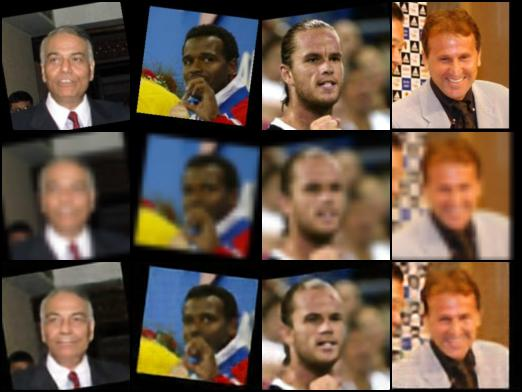

In [19]:
from IPython.display import Image,display_jpeg
from torchvision.utils import save_image

# 테스트 데이터로부터 랜덤으로 4개씩 추출하는 DataLoader
random_test_loader = DataLoader(test_data, batch_size=4, shuffle=True)

# DataLoader를 파이썬의 이터레이터로 변환해서 4개의 예로 추출
it = iter(random_test_loader)
x, y = next(it)

# Bilinear를 사용한 확대
bl_recon = torch.nn.functional.upsample(x, 128, mode="bilinear", align_corners=True)
# CNN으로 확대
yp = net(x.to("cuda:0")).to("cpu")

# torch.cat로 원본, Bilinear,CNN 이미지를 결합하고
# save_image로 결합한 이미지를 출력(저장)
save_image(torch.cat([y, bl_recon, yp], 0), "cnn_upscale.jpg", nrow=4)

display_jpeg(Image('cnn_upscale.jpg'))